In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (6,5)
AGENTS = ["B1","B2","B3","B4",
          "C1","C2","C3","C4",
          "D1","D2","D3","D4",
          "E1","E2","E3","E4"]   # any 16-agent ordering you used


In [16]:
path = "ckpt/block_normal/Ours_Attention/400_attn_per_episode.npy"
A = np.load(path)           # shape (E,16,16)
print(f"Loaded {A.shape[0]} episodes   matrix size {A.shape[1:]}")

# quick sanity-check: rows sum to 1 ?
print( np.round(A[0].sum(-1), 3) )     # should all be 1.000


Loaded 10 episodes   matrix size (16, 16)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


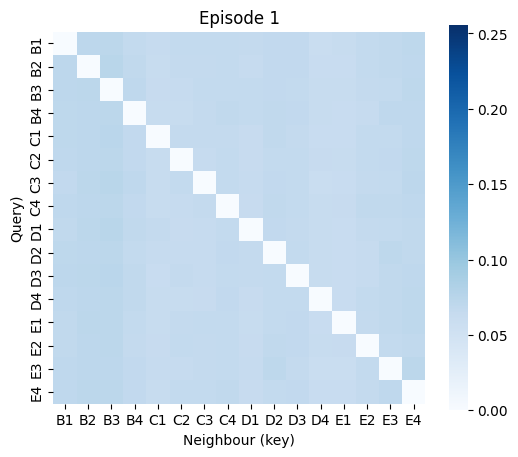

In [17]:
def show_heat(ep=0, cmap="Blues"):
    sns.heatmap(A[ep], vmax=A.max(), vmin=0,
                xticklabels=AGENTS, yticklabels=AGENTS,
                cmap=cmap, square=True, cbar=True)
    plt.title(f"Episode {ep+1}")
    plt.ylabel("Query)"); plt.xlabel("Neighbour (key)")
    plt.show()

show_heat(0)     # first episode


[[0.         0.08639688 0.05180173 0.04324036 0.0488313  0.07793568
  0.07568855 0.09539373 0.06324414 0.09927269 0.10459678 0.08426979
  0.03289605 0.05150712 0.04165953 0.04326572]
 [0.09869293 0.         0.04358261 0.044273   0.05405639 0.08381609
  0.07192736 0.10876726 0.06559487 0.07811175 0.09475867 0.08343601
  0.03230494 0.05615046 0.04409086 0.04043685]
 [0.08651133 0.08139205 0.         0.03985091 0.05247548 0.07789822
  0.0820344  0.08689667 0.06340392 0.07940879 0.10391691 0.08488537
  0.02961158 0.05591016 0.03671967 0.03908457]
 [0.09120024 0.07815105 0.04741118 0.         0.04346212 0.08493855
  0.06689156 0.09109808 0.06784809 0.08717705 0.09942712 0.08472394
  0.02961427 0.05057554 0.03833172 0.03914952]
 [0.08770729 0.08103548 0.04133073 0.0358245  0.         0.09718017
  0.06952621 0.08245762 0.06807086 0.08591338 0.09262794 0.08458795
  0.03944843 0.05636566 0.03880895 0.03911486]
 [0.08670248 0.09003554 0.04359845 0.03660995 0.05540567 0.
  0.07814752 0.09290986 0

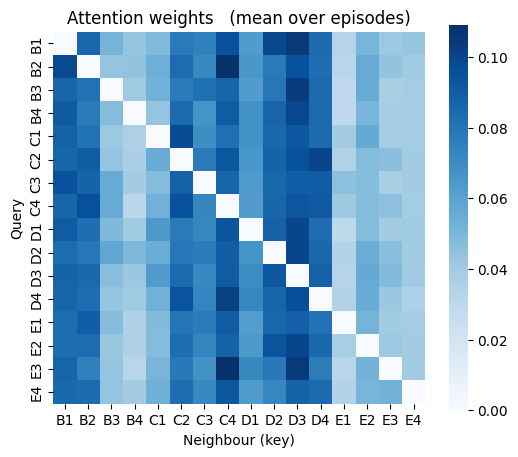

In [18]:
A_mean = A.mean(0)          # (16,16)
print(A_mean)
sns.heatmap(A_mean, vmax=A_mean.max(), vmin=0,
            xticklabels=AGENTS, yticklabels=AGENTS,
            cmap="Blues", square=True)
plt.title("Attention weights   (mean over episodes)")
plt.ylabel("Query"); plt.xlabel("Neighbour (key)")
plt.show()


In [19]:
k = 3
rows = []
for i,recv in enumerate(AGENTS):
    idx = np.argsort(A_mean[i])[::-1][:k]
    rows.append({"Agent":recv,
                 "Top-k": ", ".join([AGENTS[j] for j in idx]),
                 "Weights": ", ".join([f"{A_mean[i,j]:.2f}" for j in idx])})
pd.DataFrame(rows)


,Agent,Top-k,Weights
0,B1,"D3, D2, C4","0.10, 0.10, 0.10"
1,B2,"C4, B1, D3","0.11, 0.10, 0.09"
2,B3,"D3, C4, B1","0.10, 0.09, 0.09"
3,B4,"D3, B1, C4","0.10, 0.09, 0.09"
4,C1,"C2, D3, B1","0.10, 0.09, 0.09"
5,C2,"D4, D3, C4","0.10, 0.10, 0.09"
6,C3,"B1, D4, D3","0.09, 0.09, 0.09"
7,C4,"B2, C2, D3","0.10, 0.10, 0.09"
8,D1,"D3, C4, B1","0.10, 0.09, 0.09"
9,D2,"D3, C4, D4","0.10, 0.09, 0.09"


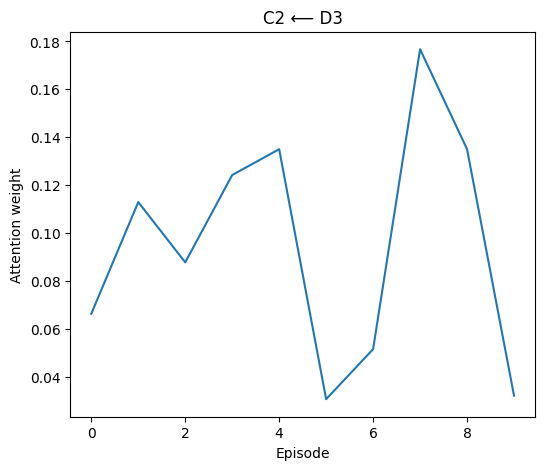

In [20]:
pair = ("C2","D3")        # receiver, neighbour
i, j = AGENTS.index(pair[0]), AGENTS.index(pair[1])

plt.plot(A[:, i, j])
plt.xlabel("Episode"); plt.ylabel("Attention weight")
plt.title(f"{pair[0]} ⟵ {pair[1]}")
plt.show()


In [21]:
def grid_heat(Amean, idx, ax=None, cmap="Blues"):
    """
    Amean : ndarray (16,16)
    idx   : int                
    """

    if ax is None:
        ax = plt.gca()

    # 1-D → 4×4 (column-major) → transpose → flip rows
    mat = Amean[idx].reshape(4, 4).T[::-1]      #   ←★ ONLY 1-LINE CHANGE

    sns.heatmap(mat,
                annot=True, fmt=".02f",
                cmap=cmap, square=True, cbar=False,
                xticklabels=["0","1","2","3"],
                yticklabels=["0","1","2","3"][::-1],
                ax=ax)
    ax.set_title(f"Agent {AGENTS[idx]}")
    ax.set_xlabel("col →")
    ax.set_ylabel("row ↑")



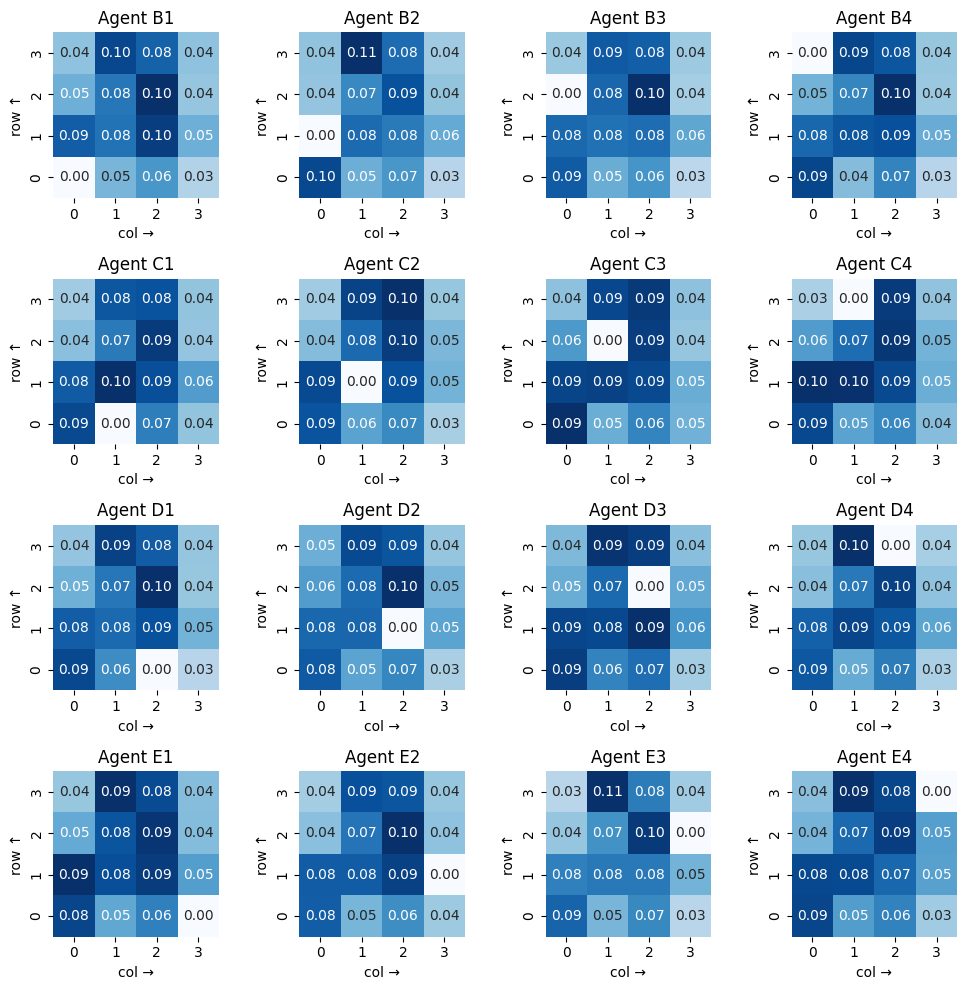

In [22]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
for k,ax in enumerate(axes.ravel()):
    grid_heat(A_mean, k, ax=ax)
plt.tight_layout(); plt.show()


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.0030196  0.0030196  0.0030196  0.0030196  0.0030196  0.0030196
 0.00969846 0.00969846 0.00969846 0.00969846 0.00969846 0.00969846
 0.00969846 0.00969846 0.00969846 0.00969846 0.00969846 0.00969846
 0.00969846 0.00969846 0.00969846 0.00969846 0.00969846 0.00969846
 0.00969846 0.00969846 0.00969846 0

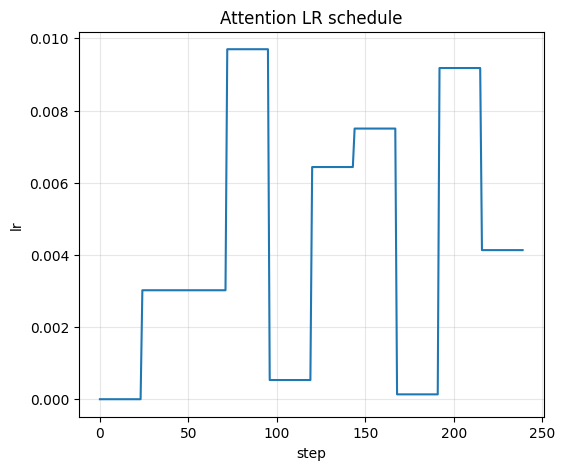

In [23]:
lrs = np.load("ckpt/block_normal/Ours_Attention/400_attn_lr_history.npy")
plt.plot(lrs)
plt.title("Attention LR schedule")
plt.xlabel("step"); plt.ylabel("lr")
plt.grid(alpha=.3)
print(lrs)
